## Import predictor variables

In [1]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Go to raster directory
raster_dir = '../data/rasters'
os.chdir(raster_dir)

In [3]:
# List all .tif files
list = glob.glob('*.tif')
list

['Zaragoza_ETRS89_MDS05.tif',
 'Zaragoza_ETRS89_Terrain_Ruggedness_Index.tif',
 'Zaragoza_ETRS89_Sky_View_Factor.tif',
 'Zaragoza_ETRS89_SWIR2.tif',
 'Zaragoza_ETRS89_Total_Insolation.tif',
 'Zaragoza_ETRS89_Visible_Sky.tif',
 'Zaragoza_ETRS89_NDVI.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_Simplified.tif',
 'Zaragoza_ETRS89_Imperviousness_Density.tif']

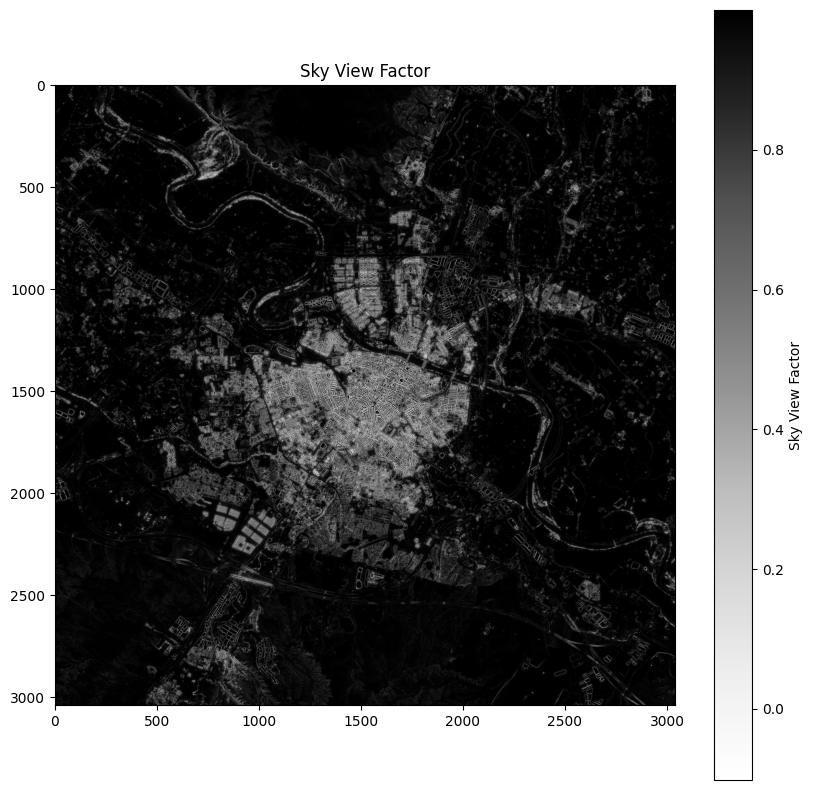

In [4]:
svf_raster_path = 'Zaragoza_ETRS89_Sky_View_Factor.tif'
with rasterio.open(svf_raster_path) as src:
    svf = src.read(1)

    # Extract coordinates for each pixel
    coords = np.array([src.transform * (col, row)
                       for row in range(src.height)
                       for col in range(src.width)])
    lons, lats = coords[:, 0], coords[:, 1]
    
plt.figure(figsize=(10, 10))
plt.imshow(svf, cmap='Grays')
plt.colorbar(label='Sky View Factor')
plt.title(f'Sky View Factor')
plt.show()

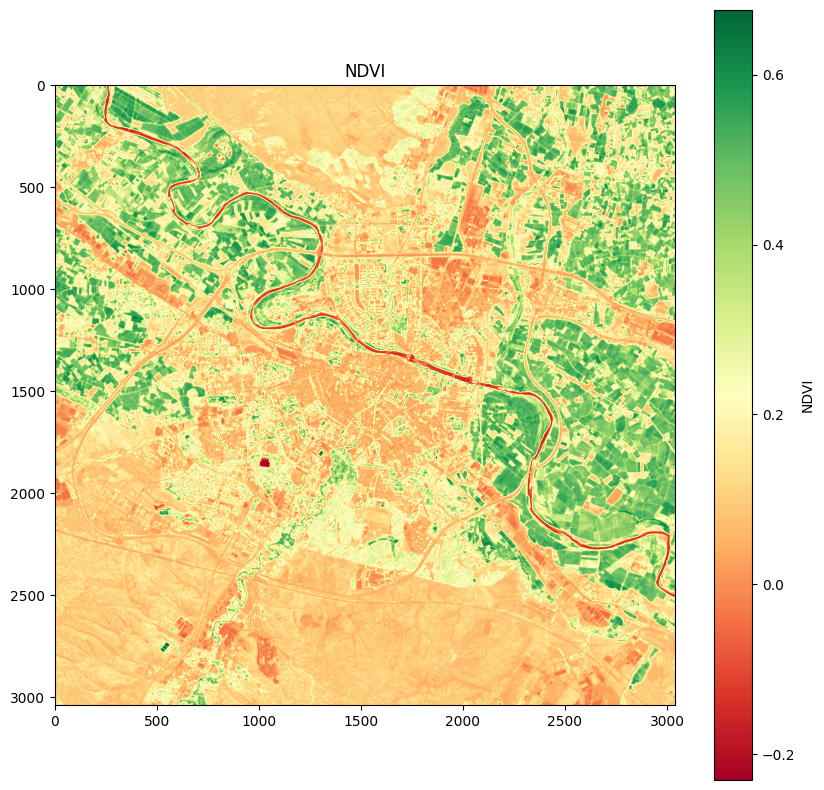

In [5]:
ndvi_raster_path = 'Zaragoza_ETRS89_NDVI.tif'
scale = 2
with rasterio.open(ndvi_raster_path) as src:
    #ndvi = src.read(1)
    ndvi = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]
    
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title(f'NDVI')
plt.show()

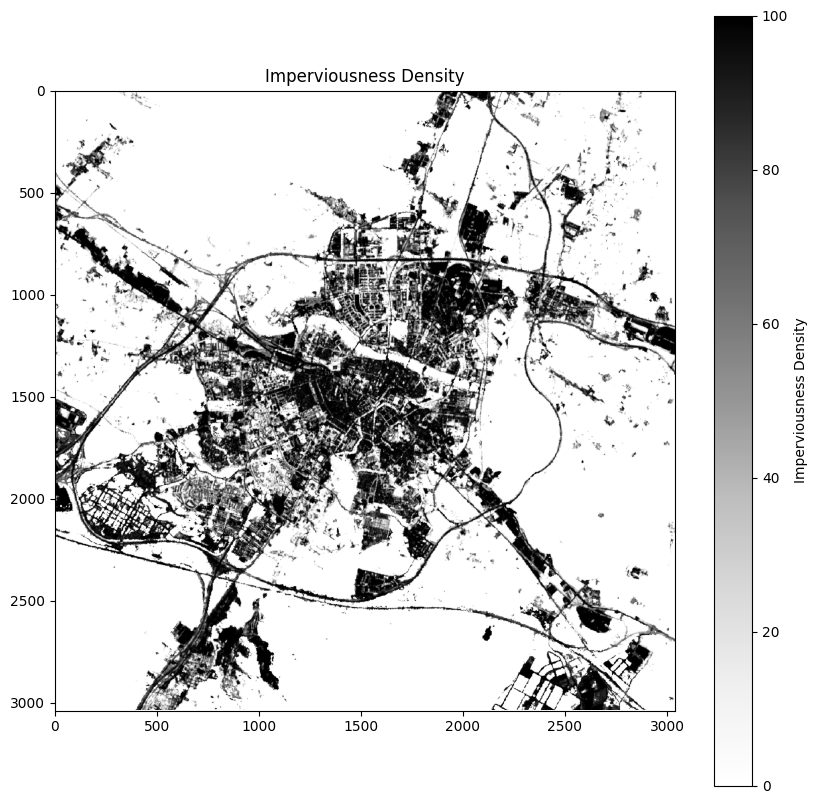

In [6]:
imd_raster_path = 'Zaragoza_ETRS89_Imperviousness_Density.tif'
with rasterio.open(imd_raster_path) as src:
    #imd = src.read(1)
    imd = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]
    
plt.figure(figsize=(10, 10))
plt.imshow(imd, cmap='Grays')
plt.colorbar(label='Imperviousness Density')
plt.title(f'Imperviousness Density')
plt.show()

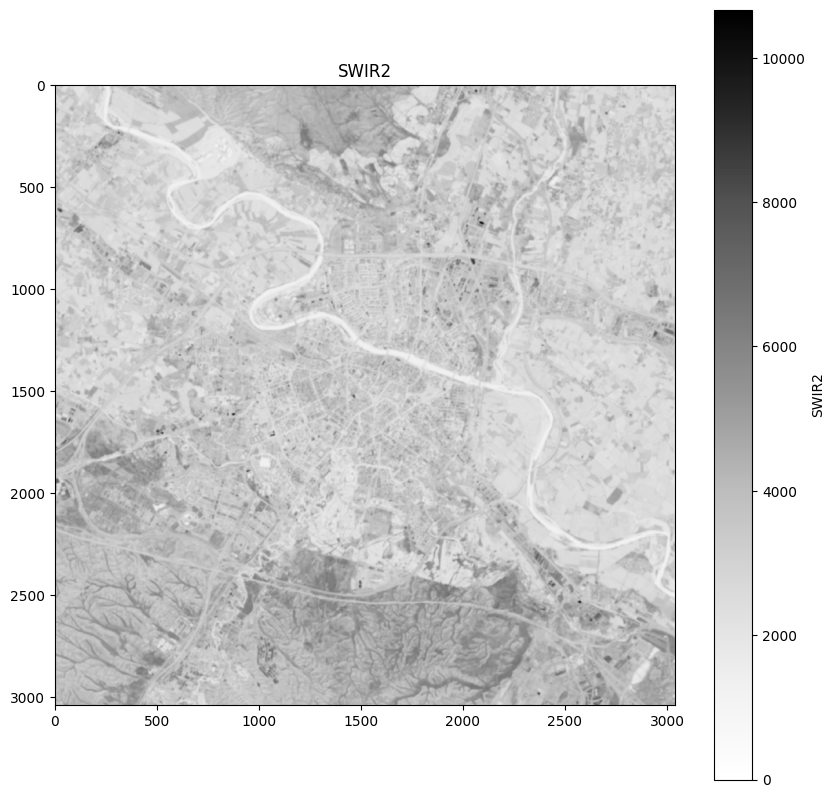

In [7]:
swir2_raster_path = 'Zaragoza_ETRS89_SWIR2.tif'
with rasterio.open(swir2_raster_path) as src:
    #swir2 = src.read(1)
    swir2 = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]
    
plt.figure(figsize=(10, 10))
plt.imshow(swir2, cmap='Grays')
plt.colorbar(label='SWIR2')
plt.title(f'SWIR2')
plt.show()

## Kriging

In [11]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pykrige.uk import UniversalKriging

In [9]:
# Flatten the coordinates and raster bands
lons = lons.flatten()
lats = lats.flatten()
svf = svf.flatten()
ndvi = ndvi.flatten()
imd = imd.flatten()
swir2 = swir2.flatten()

In [12]:
df = pd.DataFrame()

In [13]:
df['svf'] = svf
df['imd'] = imd
df['ndvi'] = ndvi
df['swir2'] = swir2
df['lat'] = lats
df['lon'] = lons

In [14]:
df.head()

,svf,imd,ndvi,swir2,lat,lon
0,0.999736,0,0.0,-1,4620567.5,668252.5
1,0.999624,0,0.0,-1,4620567.5,668257.5
2,0.999912,0,0.0,-1,4620567.5,668262.5
3,0.999158,0,0.0,-1,4620567.5,668267.5
4,0.997624,0,0.0,-1,4620567.5,668272.5


In [15]:
predictors = ['svf', 'imd', 'ndvi']
X = df[predictors].values
y = df['swir2'].values

In [16]:
def kriging_cross_validation(X, y, coordinates):
    # Set cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coord_train, coord_test = coordinates[train_index], coordinates[test_index]

        kriging_model = UniversalKriging(
            coord_train[:, 0], coord_train[:, 1], y_train,
            variogram_model="linear", drift_terms=["regional_linear"]
        )

        # Predict test data
        y_pred = [kriging_model.execute("points", x[0], x[1])[0] for x in coord_test]
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Assume coordinates
coordinates = df[['lat', 'lon']].values

# Compute RMSE
rmse_result = kriging_cross_validation(X, y, coordinates)
print(f"Average RMSE: {rmse_result}")

MemoryError: Unable to allocate 199. TiB for an array with shape (27294341800320,) and data type float64